## [F-test](https://en.wikipedia.org/wiki/F-test)

An F-test is any test where the test statistic follows an F-distribution under the null hypothesis.  An F-distribution arises from the ratio of two chi-squared distributions; for example, if $X_1, X_2$ follow chi-squared distributions with $r_1, r_2$ degrees of freedom, then $W = \frac{X_1/r_1}{X_2/r_2}$ follows an F-distribution.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

A one-way F-test compares "between-group variation" to "within group variation."  If there are $k$ groups and $n_i$ samples for group $i$,

$ \sigma_{between}^2 = \sum_{i=1}^k \frac{n_i( \bar{Y_i} - \bar{Y} )^2}{K-1} $

$ \sigma_{within}^2 = \sum_{i=1}^k \sum_{j=1}^{n_i} \frac{( Y_j - \bar{Y_i} )^2}{N-k} $

"This F-statistic [$ \frac{\sigma_{between}^2}{\sigma_{within}^2} $] follows the F-distribution with degrees of freedom $ d_{1}=K-1 $ and $ d_{2}=N-K $ under the null hypothesis. The statistic will be large if the between-group variability is large relative to the within-group variability, which is unlikely to happen if the population means of the groups all have the same value.

Note that when there are only two groups for the one-way ANOVA F-test, $ F=t^{2} $ where t is the Student's $t$ statistic."

In [63]:
n_groups = 3
group_size = 10
DIFFERENT_MEANS = True

data = list()
for group in range(n_groups):
    group_name = f"Group {group}"
    mu = np.random.normal() if DIFFERENT_MEANS else 0
    x = np.random.normal(loc=mu, size=(group_size,))
    data.extend([(group_name, _x) for _x in x])

In [64]:
df = pd.DataFrame(data, columns=['GroupName', 'Measure'])
df.head()
scipy.stats.f_oneway(*[ 
    df[df['GroupName'] == group_name]['Measure'].values 
    for group_name in df['GroupName'].unique() 
])

F_onewayResult(statistic=9.371923368878798, pvalue=0.0008108109337499424)

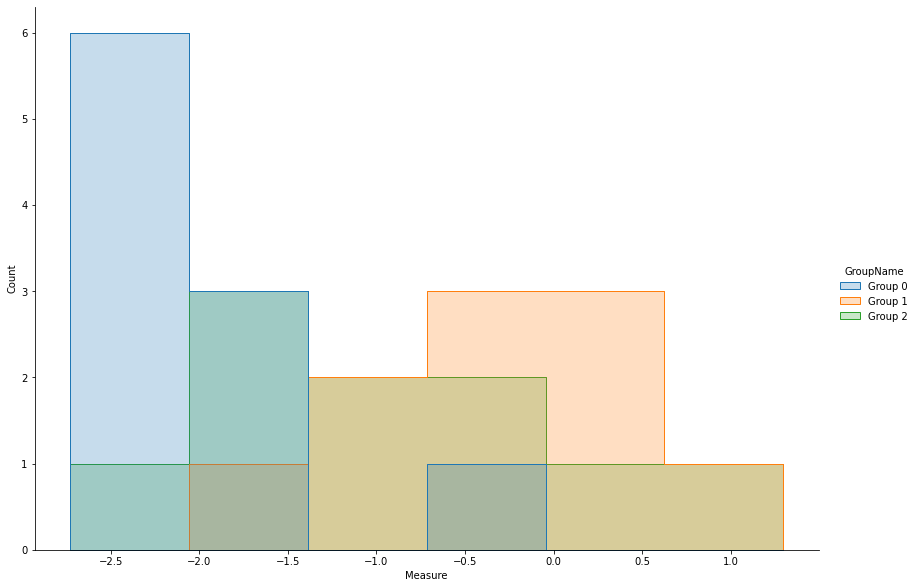

In [65]:
sns.displot(data=df, x='Measure', hue='GroupName', element='step', **dict(height=8.27, aspect=11.7/8.27))

### Application to linear models



In [375]:
import statsmodels.api as sm

In [381]:
# setup of linear eq
N = 1000
d = 5
sigma = 10

# compute linear eq w noise
beta = np.random.randint(-10, 10, size=(d,))
X = np.random.normal(size=(N, d))
eps = np.random.normal(size=(N,))*sigma
y =  eps + X.dot(beta)

In [382]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.591
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              287.2
Date:                Tue, 28 Dec 2021   Prob (F-statistic):                   3.84e-190
Time:                        12:41:44   Log-Likelihood:                         -3719.2
No. Observations:                1000   AIC:                                      7448.
Df Residuals:                     995   BIC:                                      7473.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [383]:
yh = result.predict(X)
resid = yh - y

In [384]:
# this is always true in linear model
assert np.isclose(resid.dot(resid), y.dot(y) - yh.dot(y))

(y - y.mean()).dot(yh - yh.mean())/(N*y.std()*yh.std()), scipy.stats.pearsonr(y, yh), scipy.stats.zscore(y).dot(scipy.stats.zscore(yh))/(N)

(0.768430900490317,
 (0.7684309004903175, 1.092553396909372e-195),
 0.7684309004903171)

In [385]:
# Calculations per "Applied Linear Statistical Models" (5th edition, p.225)

use_matrix = False

# too slow for d > 100 but used in theory
if use_matrix:

    H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
    J = np.ones(shape=(N, N))

    ssto = y.dot(np.eye(N) - (1/N)*J).dot(y.T)
    sse = y.dot(np.eye(N) - H).dot(y.T)
    ssr = y.dot(H - (1/N)*J).dot(y.T)

# much faster, same calculation
else:

    # equivalent: y.sum()**2/N, (y.sum()*y).sum()/N, y.mean()*y.sum()

    ssto = y.dot(y) - y.mean()*y.sum()
    sse = y.dot(y) - y.dot(yh)
    ssr = yh.dot(y) -  y.mean()*y.sum()

assert np.isclose(sse + ssr, ssto)

print("\n".join([
    f"SSTO: {round(ssto, 2)}", 
    f"SSE: {round(sse, 2)}", 
    f"SSR: {round(ssr, 2)}"
]))

SSTO: 243025.09
SSE: 99529.52
SSR: 143495.57


In [386]:
# equivalently,

ssto = N*y.std()**2             # SSTO
sse = resid.dot(resid)          # SSE
ssr = (yh - y.mean()).dot(y)    # SSR

assert np.isclose(sse + ssr, ssto)

print("\n".join([
    f"SSTO: {round(ssto, 2)}", 
    f"SSE: {round(sse, 2)}", 
    f"SSR: {round(ssr, 2)}"
]))

SSTO: 243025.09
SSE: 99529.52
SSR: 143495.57


In [387]:
# per "Applied Linear Statistical Models" p.226
msr = ssr/(d-1)
mse = sse/(N-d)
fvalue = msr/mse
fvalue

358.6325239417533

In [388]:
# SSR ~ resid.dot(resid) == y.dot(y) - yh.dot(y); called SSE in "Applied Linear Statistical Models"
ssr = resid.dot(resid)
ssr, result.ssr, y.dot(y) - yh.dot(y)

(99529.5211280049, 99529.5211280049, 99529.52112800491)

In [389]:
# mse of model
mse_model = (y.dot(y) - ssr)/result.df_model
mse_model

# mse of residual
mse_resid = ssr/(N-d)
mse_resid

print("\n".join([
    f"MSE model: {round(mse_model, 3)}",
    f"MSE residual: {round(mse_resid, 3)}"
]))

MSE model: 28725.284
MSE residual: 100.03


In [390]:
# slightly different from F-statistic in "Applied Linear Statistical Models" p.226, but close
sm_fval = mse_model/mse_resid

# confirm calculation matches statsmodels
assert np.isclose(result._results.fvalue, sm_fval)

# show differences
print("\n".join([
    f"Computed per statsmodels: {round(sm_fval, 3)}",
    f"Computed per \"Applied Linear Statistical Models\": {round(fvalue, 3)}"
]))

Computed per statsmodels: 287.168
Computed per "Applied Linear Statistical Models": 358.633


In [391]:
# compute P-value under H0 (the coefficients should be 0)
1 - scipy.stats.f(dfn=d-1, dfd=N-d).cdf(sm_fval), 1 - scipy.stats.f(dfn=d-1, dfd=N-d).cdf(fvalue)

(1.1102230246251565e-16, 1.1102230246251565e-16)